In [1]:
# Define Model

import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
import os

from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Convolution2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.optimizers import Adam
import csv
import cv2
import matplotlib.pyplot as plt
import gc
from tqdm import trange
from random import shuffle
import numpy as np
from keras.utils.np_utils import to_categorical
NUM_CHANNELS = 3
IMAGE_WIDTH = 112 # Original: 455
IMAGE_HEIGHT = 112 # Original: 256
NUM_CLASSES = 3

def preprocess(img):
    size = (IMAGE_WIDTH,IMAGE_HEIGHT)
    resized = cv2.resize(img, size)
    return resized

def load_data(fdir, lfile):
    #print("LOADING DATA FROM: %s , %s"%(fdir,lfile))
    logs = []
    features = []
    labels = []
    with open(lfile,'rt') as f:
        reader = csv.reader(f)
        for line in reader:
            logs.append(line)
        log_labels = logs.pop(0)
    
    for i in trange(len(logs), desc="Loading Data"):
        img_path = logs[i][0]
        img = cv2.imread(fdir+img_path)
        features.append(preprocess(img))
        labels.append(float(logs[i][1]))
    return features, labels




model = Sequential([
                    Convolution2D(16, 3, 3, border_mode='same', subsample=(2, 2), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CLASSES), activation='relu'),
                    MaxPooling2D(pool_size=(3, 3)),
                    Dropout(0.2),
                    
                    Convolution2D(32, 3, 3, border_mode='same', activation='relu'),
                    MaxPooling2D(pool_size=(3, 3)),
                    Dropout(0.2),
                    
                    Convolution2D(64, 3, 3, border_mode='same', activation='relu'),
                    MaxPooling2D(pool_size=(2, 2)),
                    Dropout(0.2),
                    
                    Flatten(),
                    Dense(128, activation='tanh'),
                    Dropout(0.3),
                    Dense(NUM_CLASSES, activation='softmax'),
                    ])

model.load_weights('Nexar-Weights.model')

model.summary()


Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", strides=(2, 2), activation="relu", input_shape=(112, 112,...)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          18496     
__________

In [2]:
features_directory = './data/'
labels_file = './data/labels.csv'

features, labels = load_data(features_directory, labels_file)

features = np.array(features).astype('float32')
labels = np.array(labels).astype('float32')

train_features = features[:16792]
train_labels = labels[:16792]

test_features = features[16793:]
test_labels = labels[16793:]


Loading Data: 100%|██████████| 18658/18658 [00:14<00:00, 1312.28it/s]


In [3]:
import matplotlib.pyplot as plt
#print("BEST ADVERSARIAL EXAMPLE:")
def log_image(best_image, sev, prob, statistics, image_num, true_class):
    base_name = "NEXAR-%s"%(image_num)
    
    prob = model.predict(best_image.reshape(1,112,112,3))
    new_class = np.argmax(prob[0])
    new_prob = prob[0][np.argmax(prob)]
    
    best_image = cv2.cvtColor(best_image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(best_image)
    plt.savefig("Nexar-Adv/%s-Originally-%s-PredictedAs-%s-withConfidence-%s-L0-%s-L2-%s.jpg"%(base_name, true_class, new_class, new_prob, sev[0], sev[2] ))           
    prob = model.predict(best_image.reshape(1,112,112,3))
    new_class = np.argmax(prob[0])
    new_prob = prob[0][np.argmax(prob)]
    #print("True class: %s; Predicted as: %s with confidence: %s; After %s manipulations"%(cls, new_class, new_prob, sev ))
    plt.clf()
    
    a, = plt.plot(statistics[0], label="Min Severity Found")
    b, = plt.plot(statistics[1], label="Severity per Iteration")
    c, = plt.plot(statistics[2], label="Rolling Average Severity")
    plt.legend(handles=[a,b,c], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Single Run MCTS Statisitcs")
    plt.xlabel("Iteration")
    plt.ylabel("L_0 Severity")
    plt.savefig("Nexar-Stat/%s-Originally-%s-PredictedAs-%s-withConfidence-%s-L0-%s-L2-%s.jpg"%(base_name, true_class, new_class, new_prob, sev[0], sev[2] ))           
   

In [4]:
from SafeCV_dev import *


def red_manip(p, e):
    return [0, 0, 255]
def green_manip(p, e):
    return [0, 255, 0]

L0_sevs = []
L1_sevs = []
L2_sevs = []

for i in trange(1,1001):
    img = test_features[i].astype('uint8')
    cls = int(test_labels[i])
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.savefig("Nexar-Orig/Nexar-%s.jpg"%(i))
    plt.clf()
    
    params_for_run = MCTS_Parameters(img, cls, model, predshape=(1,112,112,3))
    params_for_run.verbose = False
    params_for_run.simulations_cutoff = 100
    params_for_run.backtracking_constant = 10
    params_for_run.X_SHAPE = 112
    params_for_run.Y_SHAPE = 112
    params_for_run.VISIT_CONSTANT = 1
    params_for_run.SIGMA_CONSTNAT = 1
    params_for_run.simulations_cutoff = 10
    #params_for_run.target_class = 1
    if(cls == 0):
        params_for_run.MANIP = red_manip
    if(cls == 1):
        params_for_run.MANIP = green_manip
    if(cls == 2):
        params_for_run.MANIP = red_manip
    try:    
        best_image, sev, prob, statistics = MCTS(params_for_run)
        L0_sevs.append(sev[0])
        L1_sevs.append(sev[1])
        L2_sevs.append(sev[2])
        log_image(best_image, sev, prob, statistics, i, int(test_labels[i]))
    except:
        print("Error...")

 29%|██▉       | 290/1000 [01:33<03:48,  3.11it/s]

Error...


 36%|███▋      | 363/1000 [02:01<03:33,  2.98it/s]

Error...


100%|██████████| 1000/1000 [05:25<00:00,  3.07it/s]


In [5]:
import copy
from copy import deepcopy

lzeros = deepcopy(L0_sevs)
lones = deepcopy(L1_sevs)
ltwos = deepcopy(L2_sevs)

L0 Average: 4.96993987976


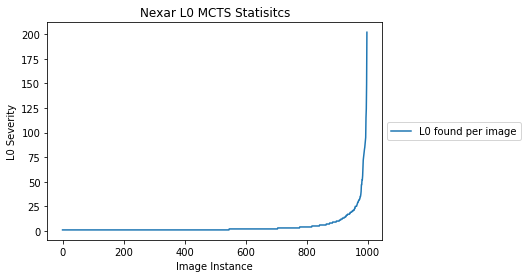

L1 Average: 0.00855593521226


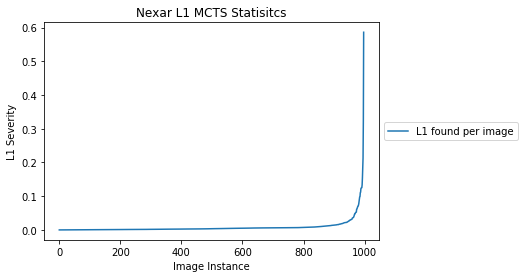

L2 Average: 0.00598562663639


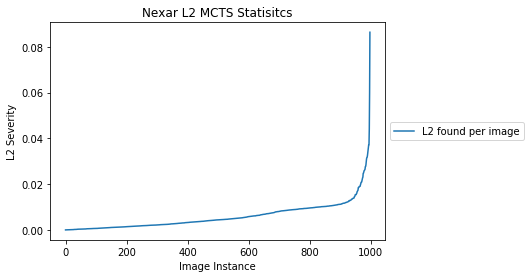

In [8]:
lzeros = sorted(lzeros)
lones = sorted(lones)
ltwos = sorted(ltwos)

print("L0 Average: %s"%(np.average(lzeros)))
plt.clf()
a, = plt.plot(lzeros, label="L0 found per image")
plt.title("Nexar L0 MCTS Statisitcs")
plt.xlabel("Image Instance")
plt.ylabel("L0 Severity")
plt.legend(handles=[a], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print("L1 Average: %s"%(np.average(lones)))
plt.clf()
a, = plt.plot(lones, label="L1 found per image")
plt.title("Nexar L1 MCTS Statisitcs")
plt.xlabel("Image Instance")
plt.ylabel("L1 Severity")
plt.legend(handles=[a], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print("L2 Average: %s"%(np.average(ltwos)))
plt.clf()
a, = plt.plot(ltwos, label="L2 found per image")
plt.title("Nexar L2 MCTS Statisitcs")
plt.xlabel("Image Instance")
plt.ylabel("L2 Severity")
plt.legend(handles=[a], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()